# Contrastive learning density estimation

Author: Christoph Weniger, June 2020

In [17]:
import numpy as np
import pylab as plt
import swyft
import torch

In [18]:
DEVICE = 'cuda:0'
NDIM = 4  # Dimensionality of parameter z
NROUNDS = 3  # Optimization rounds

In [19]:
# Generative model, x~p(x|z)
def model(z, sigma = 0.01):
    x = np.linspace(-5, 5, 50)
    t = np.sin(x)*z[0]
    t += np.cos(x)*z[1]
    t += np.sin(2*x)*z[2]
    t += np.cos(2*x)*z[3]
    n = np.random.randn(*t.shape)*sigma
    return t + n

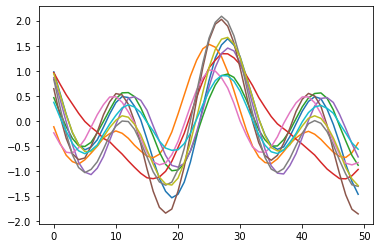

In [20]:
for i in range(10):
    z = np.random.rand(NDIM)
    x = model(z)
    plt.plot(x)

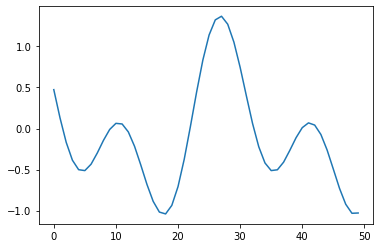

In [21]:
z0 = np.ones(NDIM)*0.5
x0 = model(z0, sigma = 1e-6)
plt.plot(x0)

In [22]:
class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.pool = torch.nn.MaxPool1d(3)
        
    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.flatten()
        return x

In [23]:
sw = swyft.SWYFT(model, NDIM, x0, device = DEVICE)

In [8]:
for i in range(NROUNDS):
    sw.round(n_sims = 10000, n_train = [3000, 3000, 3000], lr = [1e-3, 1e-4, 1e-5], n_particles = 1, head = Head().cuda())

  9%|▊         | 872/10000 [00:00<00:01, 8718.91it/s]

Round:  0
Generate samples from constrained prior: z~pc(z)
Generate corresponding draws x ~ p(x|z)


  0%|          | 4/3000 [00:00<01:18, 38.35it/s]

Network optimization


100%|██████████| 3000/3000 [01:01<00:00, 49.17it/s]


Round:  1
Generate samples from constrained prior: z~pc(z)


  8%|▊         | 811/10000 [00:00<00:01, 8107.38it/s]

Constrained posterior volume: 0.00011534325
Generate corresponding draws x ~ p(x|z)


  0%|          | 5/3000 [00:00<01:15, 39.68it/s]

Network optimization


100%|██████████| 3000/3000 [01:04<00:00, 46.79it/s]


Round:  2
Generate samples from constrained prior: z~pc(z)


 10%|▉         | 958/10000 [00:00<00:00, 9571.66it/s]

Constrained posterior volume: 1.7382599999999997e-06
Generate corresponding draws x ~ p(x|z)


  0%|          | 4/3000 [00:00<01:16, 39.10it/s]

Network optimization


100%|██████████| 3000/3000 [01:01<00:00, 48.67it/s]


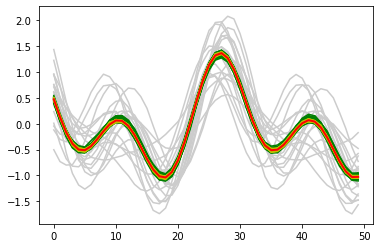

In [10]:
for i, c in enumerate(['0.8', 'g', 'y']):
    xz = sw.xz_store[i]
    x = swyft.get_x(xz)
    for spec in x[:20]:
        plt.plot(spec, color=c)
plt.plot(x0, color='r', lw=2)

In [11]:
post = []
for i in range(NROUNDS):
    post.append(sw.get_posteriors(nround=i))

(-10.0, 0.0)

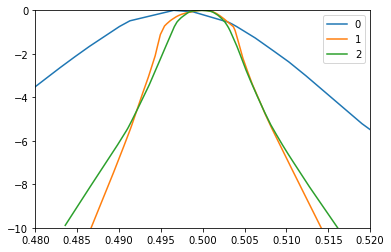

In [16]:
for i in range(NROUNDS):
    #plt.plot(post[i][0]['z'], np.exp(post[i][0]['lnL']), label=i)
    plt.plot(post[i][0]['z'], post[i][0]['lnL'], label=i)
plt.legend()
plt.xlim([0.48, 0.52])
plt.ylim([-10, 0])

In [ ]:
net = sw.net_store[4]
lnL = net(torch.tensor(x0).float().cuda(), torch.tensor(z0).float().cuda())
lnL

In [ ]:
x = net.x_mean.detach().cpu().numpy()
xs = net.x_std.detach().cpu().numpy()
plt.plot(x)
plt.plot(x+xs)

In [ ]:
z = net.z_mean.detach().cpu().numpy()
z